In [1]:
%matplotlib inline

In [2]:
import fipy as fp

In [3]:
from fipy import numerix as nmx

In [21]:
N = 50
mesh = fp.PeriodicGrid2D(nx=N, ny=N)

In [22]:
C = fp.CellVariable(mesh=mesh, name="C", hasOld=True)

In [23]:
Calpha = 0.05
Cbeta = 0.95
Cm = (Calpha + Cbeta) / 2.
A = 2.0
B = A / (Calpha - Cm)**2
D = Dalpha = Dbeta = 2 / (Cbeta - Calpha)
kappa = 2.0

In [24]:
f0 = -(A/2)*(C - Cm)**2 + (B/4)*(C - Cm)**4 + (Calpha/4)*(C - Calpha)**4 + (Cbeta/4)*(C - Cbeta)**4

In [25]:
f = f0 + (kappa/2.)*(C.grad.mag)**2
f.name = "f"

In [26]:
Cf = C.arithmeticFaceValue
eq = (fp.TransientTerm(coeff=1.)
      == fp.DiffusionTerm(coeff=D*(-A + 3*B*(Cf - Cm)**2 + 3*Calpha*(Cf - Calpha)**2 + 3*Cbeta*(Cf - Cbeta)**2))
      - fp.DiffusionTerm(coeff=(D,kappa)))

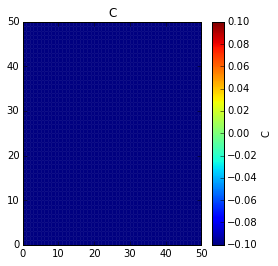

In [27]:
viewer = fp.MatplotlibViewer(vars=C)

In [28]:
epsilon = 0.01
q = [[nmx.sqrt(2.)], [nmx.sqrt(3.)]]
C.value = 0.45 + epsilon * nmx.cos(nmx.dot(q, mesh.cellCenters))

In [29]:
dt = 0.01
elapsed = 0.
saved = elapsed
duration = 10000.
step = 0

In [30]:
import os

In [31]:
os.mkdir("1a-retry")

OSError: [Errno 17] File exists: '1a-retry'

In [32]:
fp.tools.dump.write(mesh, filename="1a-retry/mesh.dmp")

In [33]:
fp.TSVViewer(vars=C).plot(filename="1a-retry/{step}.gz".format(step=0))

In [34]:
with open("1a-retry/stats.txt", 'w') as stats:
    stats.write("\t".join(["step", "t", "dt", "Cmin", "Cmax", "f"]) + "\n")

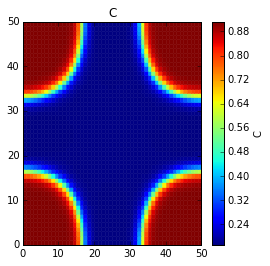

KeyboardInterrupt: 

In [35]:
while elapsed < duration:
    C.updateOld()
    for sweep in range(6):
        res = eq.sweep(C, dt=dt) #, solver=fp.LinearLUSolver())
    if res < 0.1:
        step += 1
        elapsed += dt
        dt *= 1.1
        if elapsed - saved > 10:
            fp.TSVViewer(vars=C).plot(filename="1a-retry/{step}.gz".format(step=step))
            viewer.plot()
            saved = elapsed
        with open("1a-retry/stats.txt", 'a') as stats:
            stats.write("\t".join([str(it) for it in [step, elapsed, dt, min(C), max(C), 
                                                      f.cellVolumeAverage * mesh.cellVolumes.sum()]]) + "\n")
    else:
        dt *= 0.8
        C.value = C.old.value
